##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Federated Learning for Image Classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/federated/tutorials/federated_learning_for_image_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/federated/blob/v0.86.0/docs/tutorials/federated_learning_for_image_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/federated/blob/v0.86.0/docs/tutorials/federated_learning_for_image_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/federated/docs/tutorials/federated_learning_for_image_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

**NOTE**: This colab has been verified to work with the [latest released version](https://github.com/tensorflow/federated#compatibility) of the `tensorflow_federated` pip package, but the Tensorflow Federated project is still in pre-release development and may not work on `main`.

In this tutorial, we use the classic MNIST training example to introduce the
Federated Learning (FL) API layer of TFF, `tff.learning` - a set of
higher-level interfaces that can be used to perform common types of federated
learning tasks, such as federated training, against user-supplied models
implemented in TensorFlow.

This tutorial, and the Federated Learning API, are intended primarily for users
who want to plug their own TensorFlow models into TFF, treating the latter
mostly as a black box. For a more in-depth understanding of TFF and how to
implement your own federated learning algorithms, see the tutorials on the FC Core API - [Custom Federated Algorithms Part 1](custom_federated_algorithms_1.ipynb) and [Part 2](custom_federated_algorithms_2.ipynb).

For more on `tff.learning`, continue with the
[Federated Learning for Text Generation](federated_learning_for_text_generation.ipynb),
tutorial which in addition to covering recurrent models, also demonstrates loading a
pre-trained serialized Keras model for refinement with federated learning
combined with evaluation using Keras.

## Before we start

Before we start, please run the following to make sure that your environment is
correctly setup. If you don't see a greeting, please refer to the
[Installation](../install.md) guide for instructions.

In [2]:
#@test {"skip": true}

!pip install --quiet --upgrade tensorflow-federated

In [3]:
%load_ext tensorboard

In [4]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

np.random.seed(0)

tff.federated_computation(lambda: 'Hello, World!')()

/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


b'Hello, World!'

In [5]:
!pip install --quiet --upgrade unzip
!unzip -q hit-images-final.zip

  Preparing metadata (setup.py) ... done


Step 1: Load Local Image Data


In [2]:
import tensorflow as tf
import os
import collections
import numpy as np
import tensorflow_federated as tff

# Directory paths
data_dir = 'hit-images-final'  # Replace with your actual data directory

# Load dataset
def load_local_data(data_dir):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        image_size=(28, 28),  # Assuming your images are 28x28, adjust if needed
        color_mode='grayscale',  # Since EMNIST is grayscale
        batch_size=32,  # You can adjust this as needed
        label_mode='int'  # Ensures labels are returned as integers
    )
    return dataset

# Create a dataset from the local data
dataset = load_local_data(data_dir)


Found 2354 files belonging to 4 classes.


Step 2: Preprocess the Dataset
Modify the preprocessing function to match the format expected by TensorFlow Federated:

In [6]:
NUM_CLIENTS = 10
NUM_EPOCHS = 5
BATCH_SIZE = 20
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 10
def preprocess(dataset):

    def batch_format_fn(element, label):
        """Flatten a batch of `pixels` and return the features as an `OrderedDict`."""
        element = tf.reshape(element, [-1, 784])
        label = tf.reshape(label, [-1, 1])
        return collections.OrderedDict(x=element, y=label)

    return dataset.map(batch_format_fn).repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER, seed=1).batch(BATCH_SIZE).prefetch(PREFETCH_BUFFER)

preprocessed_dataset = preprocess(dataset)


Step 3: Create Federated Data
Since TFF expects client datasets, simulate this by dividing dataset into multiple subsets, each representing a client:

In [7]:

def make_federated_data(dataset, num_clients):
    client_datasets = []
    dataset_size = len(dataset) // num_clients
    for i in range(num_clients):
        client_dataset = dataset.skip(i * dataset_size).take(dataset_size)
        client_datasets.append(preprocess(client_dataset))
    return client_datasets

federated_train_data = make_federated_data(dataset, NUM_CLIENTS)


Step 4: Train the Model
With the local data loaded and processed, you can proceed with training the model using TensorFlow Federated as before:

In [9]:
NUM_ROUNDS = 11
# Define the model function
def create_keras_model():
    return tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(784,)),
        tf.keras.layers.Dense(10, kernel_initializer='zeros'),
        tf.keras.layers.Softmax(),
    ])

def model_fn():
    keras_model = create_keras_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=preprocessed_dataset.element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

# Build the training process
training_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
)

# Initialize and train
train_state = training_process.initialize()

for round_num in range(1, NUM_ROUNDS):
    result = training_process.next(train_state, federated_train_data)
    train_state = result.state
    train_metrics = result.metrics
    print('round {:2d}, metrics={}'.format(round_num, train_metrics))


round  1, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.47678572), ('loss', 4.921197), ('num_examples', 350), ('num_batches', 20)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
round  2, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.47678572), ('loss', 8.393442), ('num_examples', 350), ('num_batches', 20)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
round  3, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.47678572), ('loss', 8.392743), ('num_examples', 350), ('num_batches', 20)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer',

 Load and Preprocess the Test Data
test data is organized similarly to your training data (i.e., categorized by directories), so load and preprocess it in the same way.

In [13]:
# Load test dataset
def load_test_data(test_data_dir):
    test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        test_data_dir,
        image_size=(28, 28),  # Assuming your images are 28x28, adjust if needed
        color_mode='grayscale',
        batch_size=32,
        label_mode='int'
    )
    return test_dataset

# Specify the path to your test dataset directory
test_data_dir = 'hit-images-final'

# Load and preprocess the test data
test_dataset = load_test_data(test_data_dir)
preprocessed_test_dataset = preprocess(test_dataset)


Found 2354 files belonging to 4 classes.


 plot example images for one client

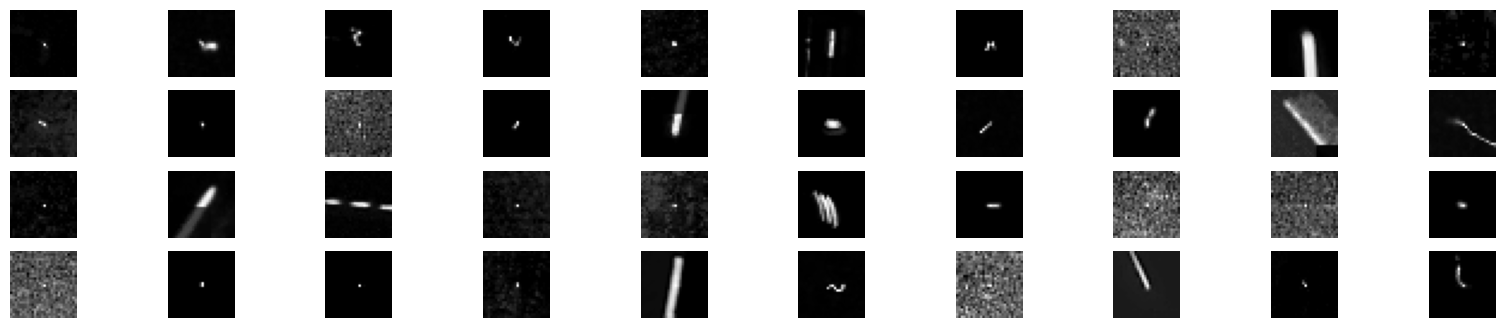

In [26]:
from matplotlib import pyplot as plt

# Visualize example images for one client
figure = plt.figure(figsize=(20, 4))
j = 0

for example in preprocessed_test_dataset.take(1):  # Taking one batch for simplicity
    images = example['x'].numpy()  # shape: (20, 32, 784)

    # Flatten and reshape each image within the batch
    for batch_idx in range(images.shape[0]):  # Iterate over the batch
        for img_idx in range(images.shape[1]):  # Iterate over the 32 images within the batch
            if j >= 40:  # Stop if we've reached 40 images
                break
            image = images[batch_idx, img_idx, :].reshape((28, 28))  # Reshape to 28x28

            plt.subplot(4, 10, j + 1)
            plt.imshow(image, cmap='gray', aspect='equal')
            plt.axis('off')
            j += 1
        if j >= 40:
            break

plt.show()


show label counts for some clients

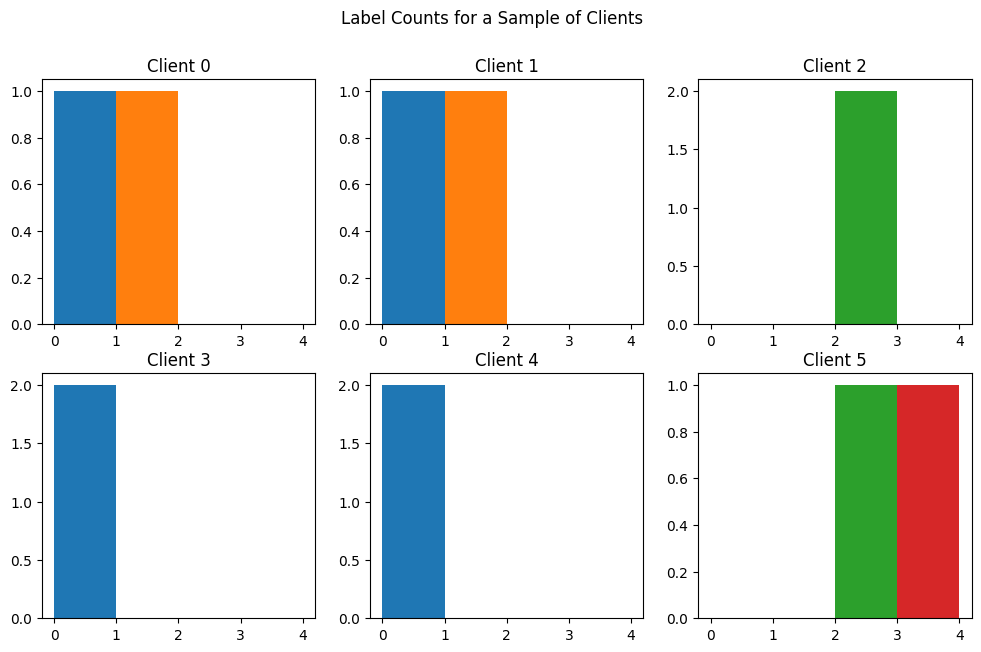

In [27]:
# Number of examples per label for a sample of clients
f = plt.figure(figsize=(12, 7))
f.suptitle('Label Counts for a Sample of Clients')

for i in range(min(6, NUM_CLIENTS)):
    client_dataset = federated_test_data[i]
    plot_data = collections.defaultdict(list)
    for example in client_dataset:
        label = example['y'].numpy().flatten()[0]
        plot_data[label].append(label)

    plt.subplot(2, 3, i + 1)
    plt.title('Client {}'.format(i))
    for j in range(4):  # Adjust based on the number of labels (4 in your case)
        plt.hist(
            plot_data[j],
            density=False,
            bins=[0, 1, 2, 3, 4]  # Adjust based on the number of labels
        )
plt.show()


Plotting Mean Images Per Label for Clients

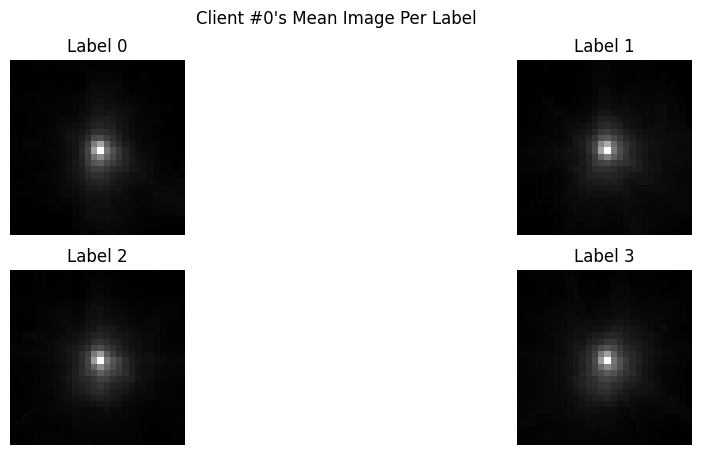

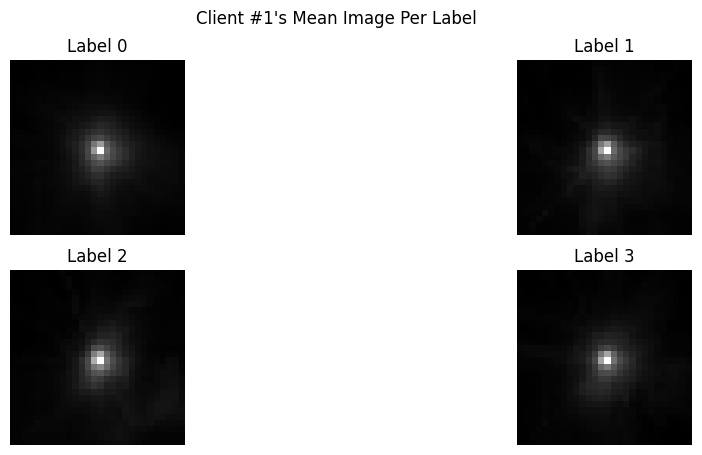

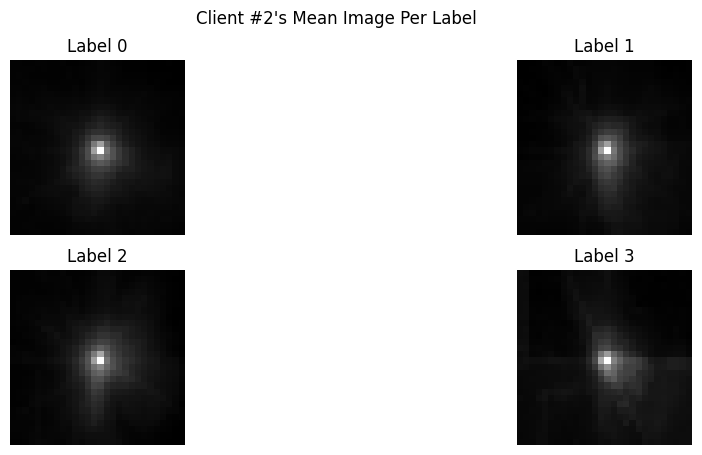

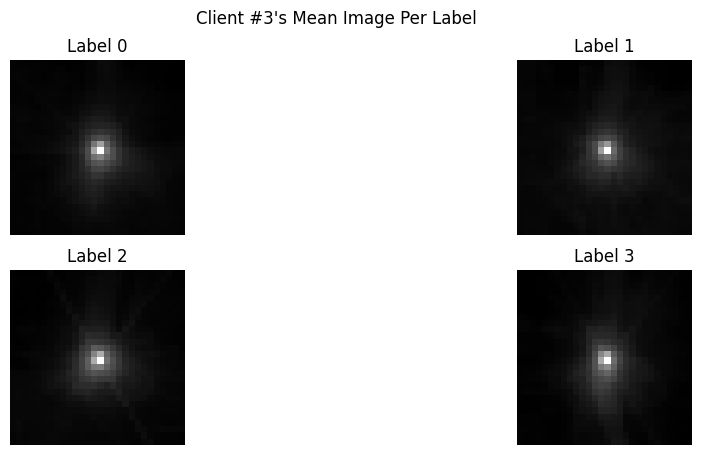

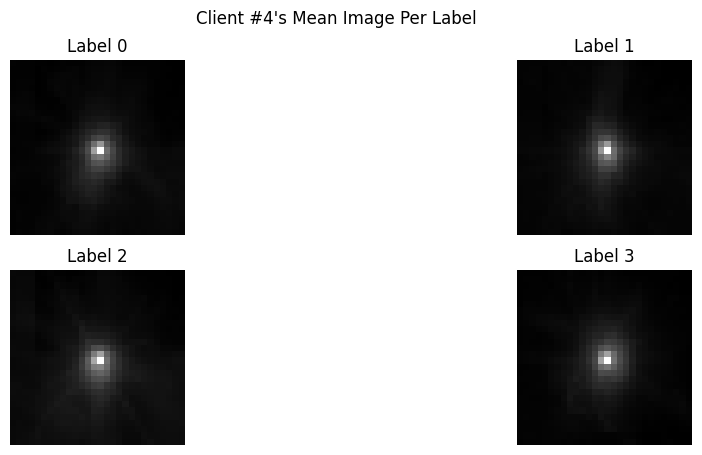

In [31]:
import numpy as np
from matplotlib import pyplot as plt

for i in range(min(5, NUM_CLIENTS)):
    client_dataset = federated_test_data[i]
    plot_data = collections.defaultdict(list)

    for example in client_dataset:
        images = example['x'].numpy()  # shape: (batch_size, 32, 784)
        labels = example['y'].numpy().flatten()  # Assuming shape: (batch_size,)

        # Ensure correct association of images with labels
        for batch_idx in range(images.shape[0]):  # Iterate over the batch
            for img_idx in range(images.shape[1]):  # Iterate over images in the batch
                image = images[batch_idx, img_idx, :].reshape((28, 28))  # Reshape to 28x28
                label = labels[batch_idx]  # Get the correct label
                plot_data[label].append(image)  # Group images by label

    # Plot mean images for each label
    f = plt.figure(i, figsize=(12, 5))
    f.suptitle("Client #{}'s Mean Image Per Label".format(i))

    for j in range(4):  # Assuming you have 4 labels: 0, 1, 2, 3
        if plot_data[j]:  # Check if there are images for this label
            mean_img = np.mean(plot_data[j], axis=0)  # Calculate mean image

            plt.subplot(2, 2, j + 1)
            plt.imshow(mean_img, cmap='gray', aspect='equal')
            plt.title(f"Label {j}")
            plt.axis('off')

    plt.show()


Create Federated Test Data
As with the training data, create a federated version of your test data:

In [14]:
federated_test_data = make_federated_data(test_dataset, NUM_CLIENTS)


Evaluate the Model
Use TensorFlow Federated evaluation process to evaluate the model on the federated test data:

In [15]:
# Build the evaluation process
evaluation_process = tff.learning.algorithms.build_fed_eval(model_fn)

# Initialize the evaluation state
evaluation_state = evaluation_process.initialize()

# Set the model weights from the final trained state
model_weights = training_process.get_model_weights(train_state)
evaluation_state = evaluation_process.set_model_weights(evaluation_state, model_weights)

# Evaluate the model on the federated test data
evaluation_output = evaluation_process.next(evaluation_state, federated_test_data)

# Print the evaluation metrics
print('Evaluation metrics:', evaluation_output.metrics)


Evaluation metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('eval', OrderedDict([('current_round_metrics', OrderedDict([('sparse_categorical_accuracy', 0.47678572), ('loss', 8.389339), ('num_examples', 350), ('num_batches', 20)])), ('total_rounds_metrics', OrderedDict([('sparse_categorical_accuracy', 0.47678572), ('loss', 8.389339), ('num_examples', 350), ('num_batches', 20)]))]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


## Preparing the input data

Let's start with the data. Federated learning requires a federated data set,
i.e., a collection of data from multiple users. Federated data is typically
non-[i.i.d.](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables),
which poses a unique set of challenges.

In order to facilitate experimentation, we seeded the TFF repository with a few
datasets, including a federated version of MNIST that contains a version of the [original NIST dataset](https://www.nist.gov/srd/nist-special-database-19) that has been re-processed using [Leaf](https://github.com/TalwalkarLab/leaf) so that the data is keyed by the original writer of the digits. Since each writer has a unique style, this dataset exhibits the kind of non-i.i.d. behavior expected of federated datasets.

Here's how we can load it.

In [ ]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

The data sets returned by `load_data()` are instances of
`tff.simulation.ClientData`, an interface that allows you to enumerate the set
of users, to construct a `tf.data.Dataset` that represents the data of a
particular user, and to query the structure of individual elements. Here's how
you can use this interface to explore the content of the data set. Keep in mind
that while this interface allows you to iterate over clients ids, this is only a
feature of the simulation data. As you will see shortly, client identities are
not used by the federated learning framework - their only purpose is to allow
you to select subsets of the data for simulations.

In [ ]:
len(emnist_train.client_ids)

3383

In [ ]:
emnist_train.element_type_structure

OrderedDict([('label', TensorSpec(shape=(), dtype=tf.int32, name=None)), ('pixels', TensorSpec(shape=(28, 28), dtype=tf.float32, name=None))])

In [ ]:
example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])

example_element = next(iter(example_dataset))

example_element['label'].numpy()

1

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(example_element['pixels'].numpy(), cmap='gray', aspect='equal')
plt.grid(False)
_ = plt.show()

### Exploring heterogeneity in federated data

Federated data is typically non-[i.i.d.](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables), users typically have different distributions of data depending on usage patterns. Some clients may have fewer training examples on device, suffering from data paucity locally, while some clients will have more than enough training examples. Let's explore this concept of data heterogeneity typical of a federated system with the EMNIST data we have available. It's important to note that this deep analysis of a client's data is only available to us because this is a simulation environment where all the data is available to us locally. In a real production federated environment you would not be able to inspect a single client's data.

First, let's grab a sampling of one client's data to get a feel for the examples on one simulated device. Because the dataset we're using has been keyed by unique writer, the data of one client represents the handwriting of one person for a sample of the digits 0 through 9, simulating the unique "usage pattern" of one user.

In [ ]:
## Example MNIST digits for one client
figure = plt.figure(figsize=(20, 4))
j = 0

for example in example_dataset.take(40):
  plt.subplot(4, 10, j+1)
  plt.imshow(example['pixels'].numpy(), cmap='gray', aspect='equal')
  plt.axis('off')
  j += 1

Now let's visualize the number of examples on each client for each MNIST digit label. In the federated environment, the number of examples on each client can vary quite a bit, depending on user behavior.

In [ ]:
# Number of examples per layer for a sample of clients
f = plt.figure(figsize=(12, 7))
f.suptitle('Label Counts for a Sample of Clients')
for i in range(6):
  client_dataset = emnist_train.create_tf_dataset_for_client(
      emnist_train.client_ids[i])
  plot_data = collections.defaultdict(list)
  for example in client_dataset:
    # Append counts individually per label to make plots
    # more colorful instead of one color per plot.
    label = example['label'].numpy()
    plot_data[label].append(label)
  plt.subplot(2, 3, i+1)
  plt.title('Client {}'.format(i))
  for j in range(10):
    plt.hist(
        plot_data[j],
        density=False,
        bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

Now let's visualize the mean image per client for each MNIST label. This code will produce the mean of each pixel value for all of the user's examples for one label. We'll see that one client's mean image for a digit will look different than another client's mean image for the same digit, due to each person's unique handwriting style. We can muse about how each local training round will nudge the model in a different direction on each client, as we're learning from that user's own unique data in that local round. Later in the tutorial we'll see how we can take each update to the model from all the clients and aggregate them together into our new global model, that has learned from each of our client's own unique data.

In [ ]:
# Each client has different mean images, meaning each client will be nudging
# the model in their own directions locally.

for i in range(5):
  client_dataset = emnist_train.create_tf_dataset_for_client(
      emnist_train.client_ids[i])
  plot_data = collections.defaultdict(list)
  for example in client_dataset:
    plot_data[example['label'].numpy()].append(example['pixels'].numpy())
  f = plt.figure(i, figsize=(12, 5))
  f.suptitle("Client #{}'s Mean Image Per Label".format(i))
  for j in range(10):
    mean_img = np.mean(plot_data[j], 0)
    plt.subplot(2, 5, j+1)
    plt.imshow(mean_img.reshape((28, 28)))
    plt.axis('off')

User data can be noisy and unreliably labeled. For example, looking at Client #2's data above, we can see that for label 2, it is possible that there may have been some mislabeled examples creating a noisier mean image.

### Preprocessing the input data

Since the data is already a `tf.data.Dataset`,  preprocessing can be accomplished using Dataset transformations. Here, we flatten the `28x28` images
into `784`-element arrays, shuffle the individual examples, organize them into batches, and rename the features
from `pixels` and `label` to `x` and `y` for use with Keras. We also throw in a
`repeat` over the data set to run several epochs.

In [ ]:
NUM_CLIENTS = 10
NUM_EPOCHS = 5
BATCH_SIZE = 20
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 10

def preprocess(dataset):

  def batch_format_fn(element):
    """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
    return collections.OrderedDict(
        x=tf.reshape(element['pixels'], [-1, 784]),
        y=tf.reshape(element['label'], [-1, 1]))

  return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER, seed=1).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

Let's verify this worked.

In [ ]:
preprocessed_example_dataset = preprocess(example_dataset)

sample_batch = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(preprocessed_example_dataset)))

sample_batch

OrderedDict([('x', array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)), ('y', array([[2],
       [1],
       [5],
       [7],
       [1],
       [7],
       [7],
       [1],
       [4],
       [7],
       [4],
       [2],
       [2],
       [5],
       [4],
       [1],
       [1],
       [0],
       [0],
       [9]], dtype=int32))])

We have almost all the building blocks in place to construct federated data
sets.

One of the ways to feed federated data to TFF in a simulation is simply as a
Python list, with each element of the list holding the data of an individual
user, whether as a list or as a `tf.data.Dataset`. Since we already have
an interface that provides the latter, let's use it.

Here's a simple helper function that will construct a list of datasets from the
given set of users as an input to a round of training or evaluation.

In [ ]:
def make_federated_data(client_data, client_ids):
  return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
  ]

Now, how do we choose clients?

In a typical federated training scenario, we are dealing with potentially a very
large population of user devices, only a fraction of which may be available for
training at a given point in time. This is the case, for example, when the
client devices are mobile phones that participate in training only when plugged
into a power source, off a metered network, and otherwise idle.

Of course, we are in a simulation environment, and all the data is locally
available. Typically then, when running simulations, we would simply sample a
random subset of the clients to be involved in each round of training, generally
different in each round.

That said, as you can find out by studying the paper on the
[Federated Averaging](https://arxiv.org/abs/1602.05629) algorithm, achieving convergence in a system with randomly sampled
subsets of clients in each round can take a while, and it would be impractical
to have to run hundreds of rounds in this interactive tutorial.

What we'll do instead is sample the set of clients once, and
reuse the same set across rounds to speed up convergence (intentionally
over-fitting to these few user's data). We leave it as an exercise for the
reader to modify this tutorial to simulate random sampling - it is fairly easy to
do (once you do, keep in mind that getting the model to converge may take a
while).

In [ ]:
sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]

federated_train_data = make_federated_data(emnist_train, sample_clients)

print(f'Number of client datasets: {len(federated_train_data)}')
print(f'First dataset: {federated_train_data[0]}')

Number of client datasets: 10
First dataset: <_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 784), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))])>


## Creating a model with Keras

If you are using Keras, you likely already have code that constructs a Keras
model. Here's an example of a simple model that will suffice for our needs.

In [ ]:
def create_keras_model():
  return tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(784,)),
      tf.keras.layers.Dense(10, kernel_initializer='zeros'),
      tf.keras.layers.Softmax(),
  ])

**Note:** we do not compile the model yet. The loss, metrics, and optimizers are introduced later.

In order to use any model with TFF, it needs to be wrapped in an instance of the
`tff.learning.models.VariableModel` interface, which exposes methods to stamp the model's
forward pass, metadata properties, etc., similarly to Keras, but also introduces
additional elements, such as ways to control the process of computing federated
metrics. Let's not worry about this for now; if you have a Keras model like the
one we've just defined above, you can have TFF wrap it for you by invoking
`tff.learning.models.from_keras_model`, passing the model and a sample data batch as
arguments, as shown below.

In [ ]:
def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.
  keras_model = create_keras_model()
  return tff.learning.models.from_keras_model(
      keras_model,
      input_spec=preprocessed_example_dataset.element_spec,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

## Training the model on federated data

Now that we have a model wrapped as `tff.learning.models.VariableModel` for use with TFF, we
can let TFF construct a Federated Averaging algorithm by invoking the helper
function `tff.learning.algorithms.build_weighted_fed_avg`, as follows.

Keep in mind that the argument needs to be a constructor (such as `model_fn`
above), not an already-constructed instance, so that the construction of your
model can happen in a context controlled by TFF (if you're curious about the
reasons for this, we encourage you to read the follow-up tutorial on
[custom algorithms](custom_federated_algorithms_1.ipynb)).

One critical note on the Federated Averaging algorithm below, there are **2**
optimizers: a _client_optimizer_ and a _server_optimizer_. The
_client_optimizer_ is only used to compute local model updates on each client.
The _server_optimizer_ applies the averaged update to the global model at the
server. In particular, this means that the choice of optimizer and learning rate
used may need to be different than the ones you have used to train the model on
a standard i.i.d. dataset. We recommend starting with regular SGD, possibly with
a smaller learning rate than usual. The learning rate we use has not been
carefully tuned, feel free to experiment.

In [ ]:
training_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0))

What just happened? TFF has constructed a pair of *federated computations* and
packaged them into a `tff.templates.IterativeProcess` in which these computations
are available as a pair of properties `initialize` and `next`.

In a nutshell, *federated computations* are programs in TFF's internal language
that can express various federated algorithms (you can find more about this in
the [custom algorithms](custom_federated_algorithms_1.ipynb) tutorial). In this
case, the two computations generated and packed into `iterative_process`
implement [Federated Averaging](https://arxiv.org/abs/1602.05629).

It is a goal of TFF to define computations in a way that they could be executed
in real federated learning settings, but currently only local execution
simulation runtime is implemented. To execute a computation in a simulator, you
simply invoke it like a Python function. This default interpreted environment is
not designed for high performance, but it will suffice for this tutorial; we
expect to provide higher-performance simulation runtimes to facilitate
larger-scale research in future releases.

Let's start with the `initialize` computation. As is the case for all federated
computations, you can think of it as a function. The computation takes no
arguments, and returns one result - the representation of the state of the
Federated Averaging process on the server. While we don't want to dive into the
details of TFF, it may be instructive to see what this state looks like. You can
visualize it as follows.

In [ ]:
print(training_process.initialize.type_signature.formatted_representation())

( -> <
  global_model_weights=<
    trainable=<
      float32[784,10],
      float32[10]
    >,
    non_trainable=<>
  >,
  distributor=<>,
  client_work=<>,
  aggregator=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  finalizer=<
    int64,
    float32[784,10],
    float32[10]
  >
>@SERVER)


While the above type signature may at first seem a bit cryptic, you can
recognize that the server state consists of a `global_model_weights` (the initial model parameters for MNIST that will be distributed to all devices), some empty parameters (like `distributor`, which governs the server-to-client communication) and a `finalizer` component. This last one governs the logic that the server uses to update its model at the end of a round, and contains an integer representing how many rounds of FedAvg have occurred.

Let's invoke the `initialize` computation to construct the server state.

In [ ]:
train_state = training_process.initialize()

The second of the pair of federated computations, `next`, represents a single
round of Federated Averaging, which consists of pushing the server state
(including the model parameters) to the clients, on-device training on their
local data, collecting and averaging model updates, and producing a new updated
model at the server.

Conceptually, you can think of `next` as having a functional type signature that
looks as follows.

```
SERVER_STATE, FEDERATED_DATA -> SERVER_STATE, TRAINING_METRICS
```

In particular, one should think about `next()` not as being a function that runs on a server, but rather being a declarative functional representation of the entire decentralized computation - some of the inputs are provided by the server (`SERVER_STATE`), but each participating device contributes its own local dataset.

Let's run a single round of training and visualize the results. We can use the
federated data we've already generated above for a sample of users.

In [ ]:
result = training_process.next(train_state, federated_train_data)
train_state = result.state
train_metrics = result.metrics
print('round  1, metrics={}'.format(train_metrics))

round  1, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.12345679), ('loss', 3.1193733), ('num_examples', 4860), ('num_batches', 248)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])


Let's run a few more rounds. As noted earlier, typically at this point you would
pick a subset of your simulation data from a new randomly selected sample of
users for each round in order to simulate a realistic deployment in which users
continuously come and go, but in this interactive notebook, for the sake of
demonstration we'll just reuse the same users, so that the system converges
quickly.

In [ ]:
NUM_ROUNDS = 11
for round_num in range(2, NUM_ROUNDS):
  result = training_process.next(train_state, federated_train_data)
  train_state = result.state
  train_metrics = result.metrics
  print('round {:2d}, metrics={}'.format(round_num, train_metrics))

round  2, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.14012346), ('loss', 2.9851403), ('num_examples', 4860), ('num_batches', 248)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
round  3, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.1590535), ('loss', 2.8617127), ('num_examples', 4860), ('num_batches', 248)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
round  4, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.17860082), ('loss', 2.7401376), ('num_examples', 4860), ('num_batches', 248)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('fin

Training loss is decreasing after each round of federated training, indicating
the model is converging. There are some important caveats with these training
metrics, however, see the section on *Evaluation* later in this tutorial.

## Displaying model metrics in TensorBoard
Next, let's visualize the metrics from these federated computations using Tensorboard.

Let's start by creating the directory and the corresponding summary writer to write the metrics to.


In [ ]:
#@test {"skip": true}
logdir = "/tmp/logs/scalars/training/"
try:
  tf.io.gfile.rmtree(logdir)  # delete any previous results
except tf.errors.NotFoundError as e:
  pass # Ignore if the directory didn't previously exist.
summary_writer = tf.summary.create_file_writer(logdir)
train_state = training_process.initialize()

Plot the relevant scalar metrics with the same summary writer.

In [ ]:
#@test {"skip": true}
with summary_writer.as_default():
  for round_num in range(1, NUM_ROUNDS):
    result = training_process.next(train_state, federated_train_data)
    train_state = result.state
    train_metrics = result.metrics
    for name, value in train_metrics['client_work']['train'].items():
      tf.summary.scalar(name, value, step=round_num)

Start TensorBoard with the root log directory specified above. It can take a few seconds for the data to load.

In [ ]:
#@test {"skip": true}
!ls {logdir}
%tensorboard --logdir {logdir} --port=0

In [ ]:
#@test {"skip": true}
# Uncomment and run this cell to clean your directory of old output for
# future graphs from this directory. We don't run it by default so that if
# you do a "Runtime > Run all" you don't lose your results.

# !rm -R /tmp/logs/scalars/*

In order to view evaluation metrics the same way, you can create a separate eval folder, like "logs/scalars/eval", to write to TensorBoard.

## Customizing the model implementation

Keras is the [recommended high-level model API for TensorFlow](https://medium.com/tensorflow/standardizing-on-keras-guidance-on-high-level-apis-in-tensorflow-2-0-bad2b04c819a), and we encourage using Keras models (via
`tff.learning.models.from_keras_model`) in TFF whenever possible.

However, `tff.learning` provides a lower-level model interface, `tff.learning.models.VariableModel`, that exposes the minimal functionality necessary for using a model for federated learning. Directly implementing this interface (possibly still using building blocks like `tf.keras.layers`) allows for maximum customization without modifying the internals of the federated learning algorithms.

So let's do it all over again from scratch.

### Defining model variables, forward pass, and metrics

The first step is to identify the TensorFlow variables we're going to work with.
In order to make the following code more legible, let's define a data structure
to represent the entire set. This will include variables such as `weights` and
`bias` that we will train, as well as variables that will hold various
cumulative statistics and counters we will update during training, such as
`loss_sum`, `accuracy_sum`, and `num_examples`.

In [ ]:
MnistVariables = collections.namedtuple(
    'MnistVariables', 'weights bias num_examples loss_sum accuracy_sum')

Here's a method that creates the variables. For the sake of simplicity, we
represent all statistics as `tf.float32`, as that will eliminate the need for
type conversions at a later stage. Wrapping variable initializers as lambdas is
a requirement imposed by
[resource variables](https://www.tensorflow.org/api_docs/python/tf/enable_resource_variables).

In [ ]:
def create_mnist_variables():
  return MnistVariables(
      weights=tf.Variable(
          lambda: tf.zeros(dtype=tf.float32, shape=(784, 10)),
          name='weights',
          trainable=True),
      bias=tf.Variable(
          lambda: tf.zeros(dtype=tf.float32, shape=(10)),
          name='bias',
          trainable=True),
      num_examples=tf.Variable(0.0, name='num_examples', trainable=False),
      loss_sum=tf.Variable(0.0, name='loss_sum', trainable=False),
      accuracy_sum=tf.Variable(0.0, name='accuracy_sum', trainable=False))

With the variables for model parameters and cumulative statistics in place, we
can now define the forward pass method that computes loss, emits predictions,
and updates the cumulative statistics for a single batch of input data, as
follows.

In [ ]:
def predict_on_batch(variables, x):
  return tf.nn.softmax(tf.matmul(x, variables.weights) + variables.bias)

def mnist_forward_pass(variables, batch):
  y = predict_on_batch(variables, batch['x'])
  predictions = tf.cast(tf.argmax(y, 1), tf.int32)

  flat_labels = tf.reshape(batch['y'], [-1])
  loss = -tf.reduce_mean(
      tf.reduce_sum(tf.one_hot(flat_labels, 10) * tf.math.log(y), axis=[1]))
  accuracy = tf.reduce_mean(
      tf.cast(tf.equal(predictions, flat_labels), tf.float32))

  num_examples = tf.cast(tf.size(batch['y']), tf.float32)

  variables.num_examples.assign_add(num_examples)
  variables.loss_sum.assign_add(loss * num_examples)
  variables.accuracy_sum.assign_add(accuracy * num_examples)

  return loss, predictions

Next, we define two functions that are related to local metrics, again using TensorFlow.

The first function `get_local_unfinalized_metrics` returns the unfinalized metric values (in addition to model updates, which are handled automatically) that are eligible to be aggregated to the server in a federated learning or evaluation process.

In [ ]:
def get_local_unfinalized_metrics(variables):
  return collections.OrderedDict(
      num_examples=[variables.num_examples],
      loss=[variables.loss_sum, variables.num_examples],
      accuracy=[variables.accuracy_sum, variables.num_examples])

The second function `get_metric_finalizers` returns an `OrderedDict` of `tf.function`s with the same keys (i.e., metric names) as `get_local_unfinalized_metrics`. Each `tf.function` takes in the metric's unfinalized values and computes the finalized metric.

In [ ]:
def get_metric_finalizers():
  return collections.OrderedDict(
      num_examples=tf.function(func=lambda x: x[0]),
      loss=tf.function(func=lambda x: x[0] / x[1]),
      accuracy=tf.function(func=lambda x: x[0] / x[1]))

How the local unfinalized metrics returned by `get_local_unfinalized_metrics` are aggregated across clients are specified by the `metrics_aggregator` parameter when defining the federated learning or evaluation processes. For example, in the [`tff.learning.algorithms.build_weighted_fed_avg`](https://www.tensorflow.org/federated/api_docs/python/tff/learning/algorithms/build_weighted_fed_avg) API (shown in the next section), the default value for `metrics_aggregator` is [`tff.learning.metrics.sum_then_finalize`](https://www.tensorflow.org/federated/api_docs/python/tff/learning/metrics/sum_then_finalize), which first sums the unfinalized metrics from `CLIENTS`, and then applies the metric finalizers at `SERVER`.

### Constructing an instance of `tff.learning.models.VariableModel`

With all of the above in place, we are ready to construct a model representation
for use with TFF similar to one that's generated for you when you let TFF ingest
a Keras model.

In [ ]:
import collections
from collections.abc import Callable

class MnistModel(tff.learning.models.VariableModel):

  def __init__(self):
    self._variables = create_mnist_variables()

  @property
  def trainable_variables(self):
    return [self._variables.weights, self._variables.bias]

  @property
  def non_trainable_variables(self):
    return []

  @property
  def local_variables(self):
    return [
        self._variables.num_examples, self._variables.loss_sum,
        self._variables.accuracy_sum
    ]

  @property
  def input_spec(self):
    return collections.OrderedDict(
        x=tf.TensorSpec([None, 784], tf.float32),
        y=tf.TensorSpec([None, 1], tf.int32))

  @tf.function
  def predict_on_batch(self, x, training=True):
    del training
    return predict_on_batch(self._variables, x)

  @tf.function
  def forward_pass(self, batch, training=True):
    del training
    loss, predictions = mnist_forward_pass(self._variables, batch)
    num_exmaples = tf.shape(batch['x'])[0]
    return tff.learning.models.BatchOutput(
        loss=loss, predictions=predictions, num_examples=num_exmaples)

  @tf.function
  def report_local_unfinalized_metrics(
      self) -> collections.OrderedDict[str, list[tf.Tensor]]:
    """Creates an `OrderedDict` of metric names to unfinalized values."""
    return get_local_unfinalized_metrics(self._variables)

  def metric_finalizers(
      self) -> collections.OrderedDict[str, Callable[[list[tf.Tensor]], tf.Tensor]]:
    """Creates an `OrderedDict` of metric names to finalizers."""
    return get_metric_finalizers()

  @tf.function
  def reset_metrics(self):
    """Resets metrics variables to initial value."""
    for var in self.local_variables:
      var.assign(tf.zeros_like(var))

As you can see, the abstract methods and properties defined by
`tff.learning.models.VariableModel` corresponds to the code snippets in the preceding section
that introduced the variables and defined the loss and statistics.

Here are a few points worth highlighting:

*   All state that your model will use must be captured as TensorFlow variables,
    as TFF does not use Python at runtime (remember your code should be written
    such that it can be deployed to mobile devices; see the
    [custom algorithms](custom_federated_algorithms_1.ipynb) tutorial for a more
    in-depth commentary on the reasons).
*   Your model should describe what form of data it accepts (`input_spec`), as
    in general, TFF is a strongly-typed environment and wants to determine type
    signatures for all components. Declaring the format of your model's input is
    an essential part of it.
*   Although technically not required, we recommend wrapping all TensorFlow
    logic (forward pass, metric calculations, etc.) as `tf.function`s,
    as this helps ensure the TensorFlow can be serialized, and removes the need
    for explicit control dependencies.


The above is sufficient for evaluation and algorithms like Federated SGD.
However, for Federated Averaging, we need to specify how the model should train
locally on each batch. We will specify a local optimizer when building the Federated Averaging algorithm.

### Simulating federated training with the new model

With all the above in place, the remainder of the process looks like what we've
seen already - just replace the model constructor with the constructor of our
new model class, and use the two federated computations in the iterative process
you created to cycle through training rounds.

In [ ]:
training_process = tff.learning.algorithms.build_weighted_fed_avg(
    MnistModel,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02))

In [ ]:
train_state = training_process.initialize()

In [ ]:
result = training_process.next(train_state, federated_train_data)
train_state = result.state
metrics = result.metrics
print('round  1, metrics={}'.format(metrics))

round  1, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('num_examples', 4860.0), ('loss', 3.119374), ('accuracy', 0.12345679)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])


In [ ]:
for round_num in range(2, 11):
  result = training_process.next(train_state, federated_train_data)
  train_state = result.state
  metrics = result.metrics
  print('round {:2d}, metrics={}'.format(round_num, metrics))

round  2, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('num_examples', 4860.0), ('loss', 2.98514), ('accuracy', 0.14012346)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
round  3, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('num_examples', 4860.0), ('loss', 2.8617127), ('accuracy', 0.1590535)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
round  4, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('num_examples', 4860.0), ('loss', 2.740137), ('accuracy', 0.17860082)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
round  5, metrics=OrderedDict([('distributor', ()), ('client_work', 

To see these metrics within TensorBoard, refer to the steps listed above in "Displaying model metrics in TensorBoard".

## Evaluation

All of our experiments so far presented only federated training metrics - the
average metrics over all batches of data trained across all clients in the
round. This introduces the normal concerns about overfitting, especially since
we used the same set of clients on each round for simplicity, but there is an
additional notion of overfitting in training metrics specific to the Federated
Averaging algorithm. This is easiest to see if we imagine each client had a
single batch of data, and we train on that batch for many iterations (epochs).
In this case, the local model will quickly exactly fit to that one batch, and so
the local accuracy metric we average will approach 1.0. Thus, these training
metrics can be taken as a sign that training is progressing, but not much more.

To perform evaluation on federated data, you can construct another *federated
computation* designed for just this purpose, using the
`tff.learning.build_federated_evaluation` function, and passing in your model
constructor as an argument. Note that unlike with Federated Averaging, where
we've used `MnistTrainableModel`, it suffices to pass the `MnistModel`.
Evaluation doesn't perform gradient descent, and there's no need to construct
optimizers.

For experimentation and research, when a centralized test dataset is available,
[Federated Learning for Text Generation](federated_learning_for_text_generation.ipynb)
demonstrates another evaluation option: taking the trained weights from
federated learning, applying them to a standard Keras model, and then simply
calling `tf.keras.models.Model.evaluate()` on a centralized dataset.

In [ ]:
evaluation_process = tff.learning.algorithms.build_fed_eval(MnistModel)

You can inspect the abstract type signature of the evaluation function as follows.

In [ ]:
print(evaluation_process.next.type_signature.formatted_representation())

(<
  state=<
    global_model_weights=<
      trainable=<
        float32[784,10],
        float32[10]
      >,
      non_trainable=<>
    >,
    distributor=<>,
    client_work=<
      <>,
      <
        num_examples=<
          float32
        >,
        loss=<
          float32,
          float32
        >,
        accuracy=<
          float32,
          float32
        >
      >
    >,
    aggregator=<
      value_sum_process=<>,
      weight_sum_process=<>
    >,
    finalizer=<>
  >@SERVER,
  client_data={<
    x=float32[?,784],
    y=int32[?,1]
  >*}@CLIENTS
> -> <
  state=<
    global_model_weights=<
      trainable=<
        float32[784,10],
        float32[10]
      >,
      non_trainable=<>
    >,
    distributor=<>,
    client_work=<
      <>,
      <
        num_examples=<
          float32
        >,
        loss=<
          float32,
          float32
        >,
        accuracy=<
          float32,
          float32
        >
      >
    >,
    aggregator=<
      value_

Be aware that evaluation process is a `tff.lenaring.templates.LearningProcess` object. The object has an `initialize` method that will create the state, but this will contain an untrained model at first. Using the `set_model_weights` method, one must insert the weights from the training state to be evaluated.

In [ ]:
evaluation_state = evaluation_process.initialize()
model_weights = training_process.get_model_weights(train_state)
evaluation_state = evaluation_process.set_model_weights(evaluation_state, model_weights)

Now with the evaluation state containing the model weights to be evaluated, we can compute evaluation metrics using evaluation datasets by calling the `next` method on the process, just like in training.

This will again return a `tff.learning.templates.LearingProcessOutput` instance.

In [ ]:
evaluation_output = evaluation_process.next(evaluation_state, federated_train_data)

Here's what we get. Note the numbers look marginally better than what was
reported by the last round of training above. By convention, the training
metrics reported by the iterative training process generally reflect the
performance of the model at the beginning of the training round, so the
evaluation metrics will always be one step ahead.

In [ ]:
str(evaluation_output.metrics)

"OrderedDict([('distributor', ()), ('client_work', OrderedDict([('eval', OrderedDict([('current_round_metrics', OrderedDict([('num_examples', 4860.0), ('loss', 1.6654209), ('accuracy', 0.3621399)])), ('total_rounds_metrics', OrderedDict([('num_examples', 4860.0), ('loss', 1.6654209), ('accuracy', 0.3621399)]))]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])"

Now, let's compile a test sample of federated data and rerun evaluation on the
test data. The data will come from the same sample of real users, but from a
distinct held-out data set.

In [ ]:
federated_test_data = make_federated_data(emnist_test, sample_clients)

len(federated_test_data), federated_test_data[0]

(10,
 <_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 784), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))])>)

In [ ]:
evaluation_output = evaluation_process.next(evaluation_state, federated_test_data)

In [ ]:
str(evaluation_output.metrics)

"OrderedDict([('distributor', ()), ('client_work', OrderedDict([('eval', OrderedDict([('current_round_metrics', OrderedDict([('num_examples', 580.0), ('loss', 1.7750846), ('accuracy', 0.33620688)])), ('total_rounds_metrics', OrderedDict([('num_examples', 580.0), ('loss', 1.7750846), ('accuracy', 0.33620688)]))]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])"

This concludes the tutorial. We encourage you to play with the
parameters (e.g., batch sizes, number of users, epochs, learning rates, etc.), to modify the code above to simulate training on random samples of users in
each round, and to explore the other tutorials we've developed.